In [367]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from math import sqrt
import numpy as np
import optuna
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt


data= pd.read_csv('1dataset.csv')

# Создадим таблицу для вывода
А также функцию, добавляющую метрики в датафрейм

In [368]:
table_all_metrics = pd.DataFrame(columns=['Model','MAE','MSE','RMSE','MAPE','R^2'])

In [369]:
def add_err_to_dataframe(dataframe, model_name, dict_errors):
    new_row = {'Model': model_name}
    
    # Добавляем ошибки в строку
    for error, value in dict_errors.items():
        new_row[error] = value
    
    dataframe.loc[len(dataframe)] = new_row

Добавляем строку в DataFrame .loc[] используется для доступа к строкам по метке.

Таким образом, она указывает на новую позицию после последней строки.

# Линейная регрессия

In [ ]:
# Разделение на признаки и целевую переменную
y = data['price']
X = data.drop(['price'], axis=1)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Обучение модели
lr = LinearRegression().fit(X_train, y_train)

# Предсказание
y_pred = lr.predict(X_test)


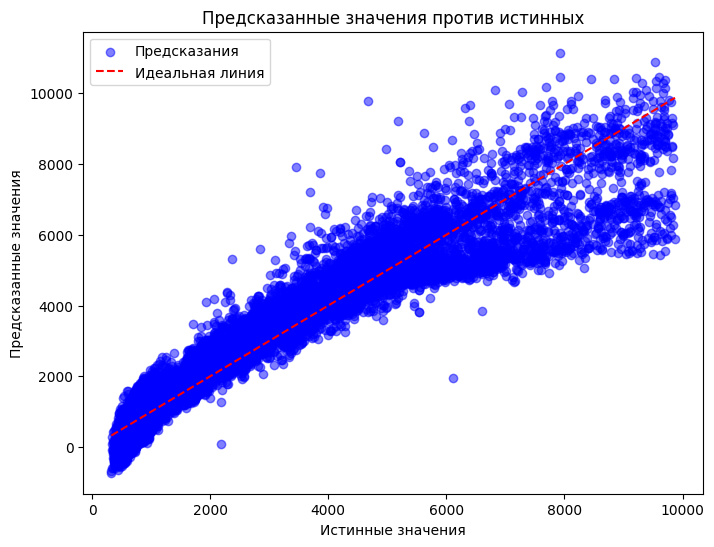

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue', label='Предсказания')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Идеальная линия')
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title('Предсказанные значения против истинных')
plt.legend()
plt.show()

Напишем функции, которые добавят метрики в таблицу

In [372]:
def dict_errors(y_pred, y_test):
  return {'MAE': mean_absolute_error(y_test, y_pred),
          'MSE': mean_squared_error(y_test, y_pred),
          'RMSE': sqrt(mean_squared_error(y_test, y_pred)),
          'MAPE': sqrt(mean_absolute_percentage_error(y_test, y_pred)),
          'R^2': r2_score(y_test, y_pred)}

In [373]:
this_dict_errors = dict_errors(y_pred, y_test)
add_err_to_dataframe(table_all_metrics, 'Linear_regression', this_dict_errors)
print(this_dict_errors)

{'MAE': 486.81617134599543, 'MSE': 512030.3868238452, 'RMSE': 715.562985923563, 'MAPE': 0.5199965117856511, 'R^2': 0.9082605909153078}


MAE (Mean Absolute Error): средняя абсолютная ошибка. Это среднее значение абсолютных отклонений предсказанных значений от истинных. Чем меньше, тем лучше.

MSE (Mean Squared Error):  среднеквадратичная ошибка. Это среднее значение квадратов ошибок (разностей между предсказанными и истинными значениями). Увеличивает вес больших ошибок. 

RMSE (Root Mean Squared Error): корень из MSE. Это более интерпретируемая метрика, так как имеет ту же единицу измерения, что и целевая переменная.

MAPE (Mean Absolute Percentage Error): средняя абсолютная процентная ошибка. Показывает, на сколько процентов в среднем ошибаются предсказания.

R² (R-квадрат): коэффициент детерминации. Показывает, какую долю дисперсии целевой переменной объясняет модель.

In [374]:
print(lr.coef_)
print(lr.intercept_)

[ 1.67081985e+04  3.63236209e+01  1.19933784e+02  2.93658499e+02
  3.56846380e+03  1.47920255e+02 -4.90989458e+03  5.88670905e+04
 -6.29321614e+04  6.70048821e+05]
-2131.1194077273926


# L1 регрессия, она же Лассо

Параметр alpha контролирует силу регуляризации:

Чем больше alpha, тем сильнее регуляризация. Это приводит к уменьшению весов признаков, возможному обнулению некоторых весов (признаки исключаются из модели), меньшей сложности модели, но потенциально большей ошибке на обучающих данных.

In [375]:
alpha_values = {'alpha': np.linspace(0.1, 1, 20)}
grid_search = GridSearchCV(Lasso(), alpha_values).fit(X_train, y_train)
y_pred_lasso_grid = grid_search.predict(X_test)
this_dict_errors = dict_errors(y_pred_lasso_grid, y_test)
add_err_to_dataframe(table_all_metrics, 'Lasso_grid', this_dict_errors)
print(this_dict_errors)

{'MAE': 491.89680337342185, 'MSE': 517254.5098288733, 'RMSE': 719.2040807927006, 'MAPE': 0.5262074623564938, 'R^2': 0.9073245957677544}


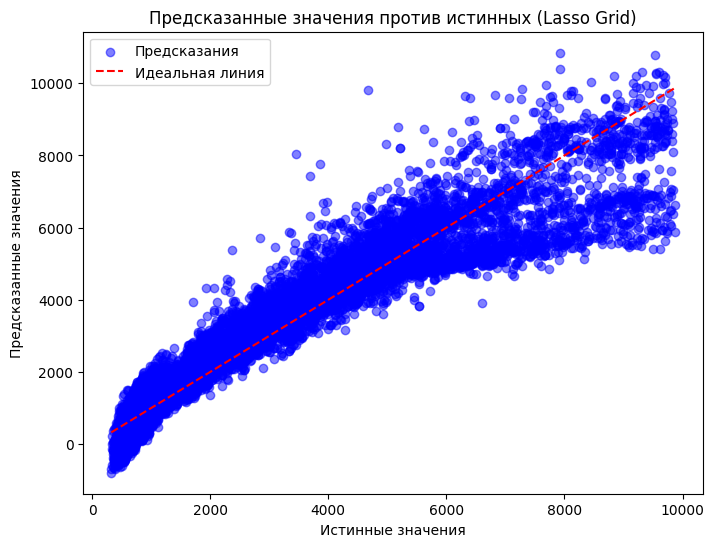

In [376]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lasso_grid, alpha=0.5, color='blue', label='Предсказания')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Идеальная линия')
plt.xlabel("Истинные значения")
plt.ylabel("Предсказанные значения")
plt.title("Предсказанные значения против истинных (Lasso Grid)")
plt.legend()
plt.show()

In [ ]:
random_search = RandomizedSearchCV(
        Lasso(),
        param_distributions= alpha_values,
        n_iter=20,
        random_state=42,
    ).fit(X_train, y_train)
y_pred_lasso_rand = random_search.predict(X_test)
this_dict_errors = dict_errors(y_pred_lasso_rand, y_test)
add_err_to_dataframe(table_all_metrics, 'Lasso_random', this_dict_errors)
print(this_dict_errors)

{'MAE': 491.89680337342185, 'MSE': 517254.5098288733, 'RMSE': 719.2040807927006, 'MAPE': 0.5262074623564938, 'R^2': 0.9073245957677544}


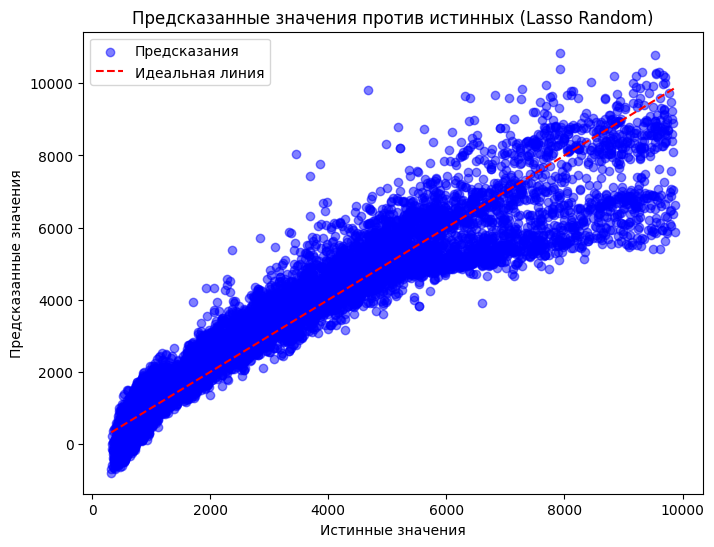

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lasso_rand, alpha=0.5, color='blue', label='Предсказания')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Идеальная линия')
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title('Предсказанные значения против истинных (Lasso Random)')
plt.legend()
plt.show()

In [379]:
# Функция для оптимизации гиперпараметров с использованием Optuna
def objective_lasso(trial):
    # Задаем гиперпараметры для поиска
    alpha = trial.suggest_float('alpha', 1e-3, 1e2, log=True)  # логарифмический диапазон
    lasso = Lasso(alpha=alpha)
    
    # Вычисляем среднюю ошибку на кросс-валидации
    score = cross_val_score(lasso, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    return score.mean()

In [380]:
study = optuna.create_study(direction='maximize') 
study.optimize(objective_lasso, n_trials=20)  
    
# Получаем лучшие параметры и обучаем модель
best_params = study.best_params
lasso = Lasso(**best_params)
lasso.fit(X_train, y_train)
y_pred_lasso_optuna = lasso.predict(X_test)
this_dict_errors = dict_errors(y_pred_lasso_optuna, y_test)
add_err_to_dataframe(table_all_metrics, 'Lasso_optuna', this_dict_errors)
print(this_dict_errors)


[I 2025-05-02 01:10:05,524] A new study created in memory with name: no-name-82ae2d0e-c1bb-4b27-a601-30d0d1556f2a
[I 2025-05-02 01:10:06,411] Trial 0 finished with value: -661250.7651421023 and parameters: {'alpha': 16.74720664880492}. Best is trial 0 with value: -661250.7651421023.
[I 2025-05-02 01:10:06,513] Trial 1 finished with value: -540416.533538306 and parameters: {'alpha': 0.905678058957245}. Best is trial 1 with value: -540416.533538306.
[I 2025-05-02 01:10:06,629] Trial 2 finished with value: -541124.6179601653 and parameters: {'alpha': 1.9103675837696503}. Best is trial 1 with value: -540416.533538306.
c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.131e+07, tolerance: 1.399e+07
  model = cd_fast.enet_coordinate_descen

{'MAE': 487.03216608707453, 'MSE': 511964.1593867987, 'RMSE': 715.5167079717976, 'MAPE': 0.520684433480436, 'R^2': 0.9082724567461182}


c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.028e+09, tolerance: 1.750e+07
  model = cd_fast.enet_coordinate_descent(


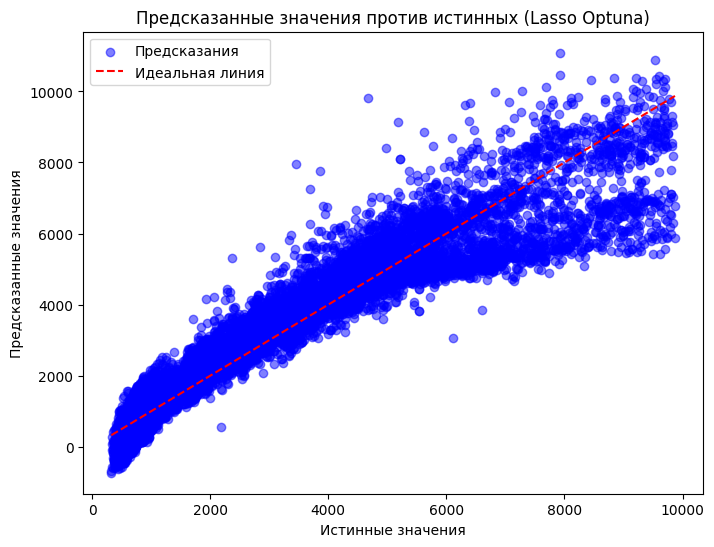

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lasso_optuna, alpha=0.5, color='blue', label='Предсказания')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Идеальная линия')
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title('Предсказанные значения против истинных (Lasso Optuna)')
plt.legend()
plt.show()

# L2 (Ridge)

GridSearch, RandomSearch и Optuna — это методы оптимизации гиперпараметров для машинного обучения, но они отличаются подходом, эффективностью и гибкостью.

GridSearch (поиск по сетке):
Перебирает все возможные комбинации гиперпараметров из заданного набора значений (сетки). Например, если у вас есть два параметра с 3 значениями каждый, GridSearch проверит 3×3=9 комбинаций.

+: Полный перебор, гарантирует нахождение лучшей комбинации в заданной сетке.

-: Очень медленный при большом количестве параметров или значений, так как вычислительная сложность растет экспоненциально. Неэффективен для больших пространств поиска.

In [382]:
alpha_values = {'alpha': np.linspace(0.1, 1, 20)}
grid_search = GridSearchCV(Ridge(), alpha_values).fit(X_train, y_train)
y_pred_ridge_grid = grid_search.predict(X_test)
this_dict_errors = dict_errors(y_pred_ridge_grid, y_test)
add_err_to_dataframe(table_all_metrics, 'Ridge_grid', this_dict_errors)
print(this_dict_errors)

{'MAE': 491.13394112416137, 'MSE': 516706.5148281532, 'RMSE': 718.8230066074354, 'MAPE': 0.5253271575848478, 'R^2': 0.9074227788811811}


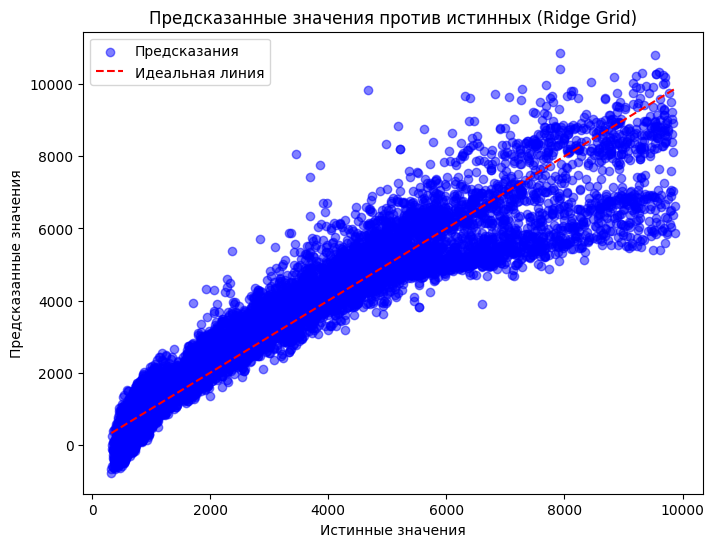

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_ridge_grid, alpha=0.5, color='blue', label='Предсказания')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Идеальная линия')
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title('Предсказанные значения против истинных (Ridge Grid)')
plt.legend()
plt.show()

RandomSearch (случайный поиск):
Вместо перебора всех комбинаций случайным образом выбирает заданное количество комбинаций гиперпараметров из заданного диапазона. Например, может выбрать 10 случайных комбинаций вместо полного перебора.

+: Быстрее, чем GridSearch, особенно в больших пространствах поиска. Часто находит хорошие параметры за меньшее время, так как не тратит ресурсы на заведомо плохие комбинации.

-: Нет гарантии нахождения оптимального решения, так как выбор случаен. Может пропустить лучшие параметры.

In [384]:
random_search = RandomizedSearchCV(
        Ridge(),
        param_distributions= alpha_values,
        n_iter=20,
        random_state=42,
    ).fit(X_train, y_train)
y_pred_ridge_rand = random_search.predict(X_test)
this_dict_errors = dict_errors(y_pred_ridge_rand, y_test)
add_err_to_dataframe(table_all_metrics, 'Ridge_random', this_dict_errors)
print(this_dict_errors)

{'MAE': 491.13394112416137, 'MSE': 516706.5148281532, 'RMSE': 718.8230066074354, 'MAPE': 0.5253271575848478, 'R^2': 0.9074227788811811}


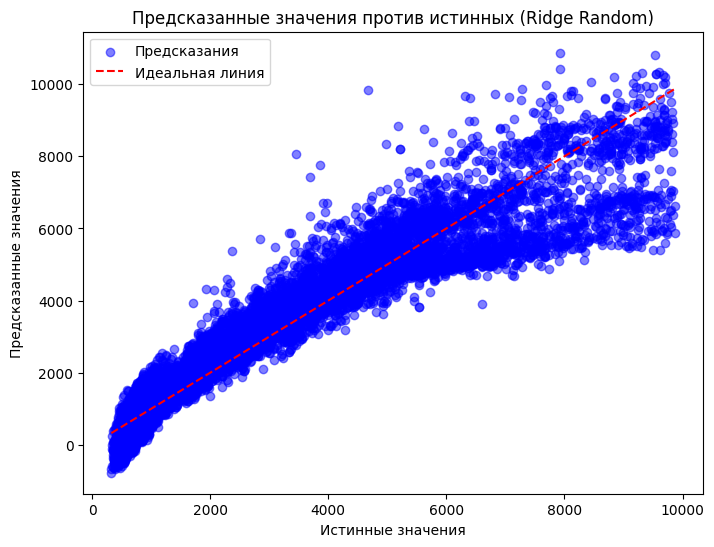

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_ridge_rand, alpha=0.5, color='blue', label='Предсказания')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Идеальная линия')
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title('Предсказанные значения против истинных (Ridge Random)')
plt.legend()
plt.show()

Optuna:
Это библиотека для оптимизации гиперпараметров, использующая байесовский подход (TPE — Tree-structured Parzen Estimator) для интеллектуального поиска. Вместо случайного перебора или полного перебора Optuna анализирует результаты предыдущих итераций и выбирает более перспективные комбинации гиперпараметров.

+: Намного эффективнее GridSearch и RandomSearch, особенно в сложных пространствах. Может динамически определять диапазоны поиска и поддерживает условные параметры (например, "если выбран алгоритм X, то оптимизировать параметры Y"). Также позволяет обрывать неудачные итерации (pruning).

-: Более сложная настройка по сравнению с GridSearch и RandomSearch. Требует понимания работы байесовской оптимизации для максимальной эффективности.

In [386]:
# Функция для оптимизации гиперпараметров с использованием Optuna
def objective_ridge(trial):
    # Задаем гиперпараметры для поиска
    alpha = trial.suggest_float('alpha', 1e-3, 1e2, log=True)  # логарифмический диапазон
    ridge = Ridge(alpha=alpha)
    
    # Вычисляем среднюю ошибку на кросс-валидации
    score = cross_val_score(ridge, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    return score.mean()

In [387]:
study = optuna.create_study(direction='maximize') 
study.optimize(objective_ridge, n_trials=100)  
    
# Получаем лучшие параметры и обучаем модель
best_params = study.best_params
ridge = Ridge(**best_params)
ridge.fit(X_train, y_train)
y_pred_ridge_optuna = ridge.predict(X_test)
this_dict_errors = dict_errors(y_pred_ridge_optuna, y_test)
add_err_to_dataframe(table_all_metrics, 'ridge_optuna', this_dict_errors)
print(this_dict_errors)

[I 2025-05-02 01:11:04,190] A new study created in memory with name: no-name-387d40e8-0465-4c1a-9a2e-c8cfbfb372e7
[I 2025-05-02 01:11:04,219] Trial 0 finished with value: -532737.2441650964 and parameters: {'alpha': 0.03581805892467229}. Best is trial 0 with value: -532737.2441650964.
[I 2025-05-02 01:11:04,247] Trial 1 finished with value: -532471.0514017569 and parameters: {'alpha': 0.02215837019700515}. Best is trial 1 with value: -532471.0514017569.
[I 2025-05-02 01:11:04,273] Trial 2 finished with value: -583454.9964771431 and parameters: {'alpha': 4.63555446909961}. Best is trial 1 with value: -532471.0514017569.
[I 2025-05-02 01:11:04,299] Trial 3 finished with value: -537737.8779961271 and parameters: {'alpha': 0.4952505891717643}. Best is trial 1 with value: -532471.0514017569.
[I 2025-05-02 01:11:04,324] Trial 4 finished with value: -563385.1220939184 and parameters: {'alpha': 2.3040089374586925}. Best is trial 1 with value: -532471.0514017569.
[I 2025-05-02 01:11:04,349] Tri

{'MAE': 489.20218463918434, 'MSE': 514009.99120500527, 'RMSE': 716.944901094223, 'MAPE': 0.5231731934005489, 'R^2': 0.9079059093557316}


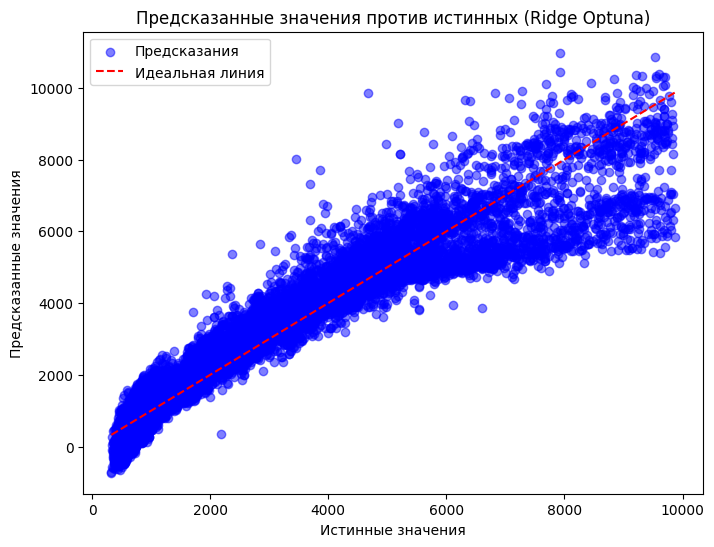

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_ridge_optuna, alpha=0.5, color='blue', label='Предсказания')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Идеальная линия')
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title('Предсказанные значения против истинных (Ridge Optuna)')
plt.legend()
plt.show()

# Elastic Net (линейная регрессия с двумя регуляризаторами)

In [389]:
alpha_values = {'alpha': np.linspace(0.1, 1, 20)}
grid_search = GridSearchCV(ElasticNet(), alpha_values).fit(X_train, y_train)
y_pred_elastic_grid = grid_search.predict(X_test)
this_dict_errors = dict_errors(y_pred_elastic_grid, y_test)
add_err_to_dataframe(table_all_metrics, 'Elastic_grid', this_dict_errors)
print(this_dict_errors)

{'MAE': 1534.0291926616273, 'MSE': 3767893.735953412, 'RMSE': 1941.1063175296226, 'MAPE': 1.0348855314124745, 'R^2': 0.3249143923382052}


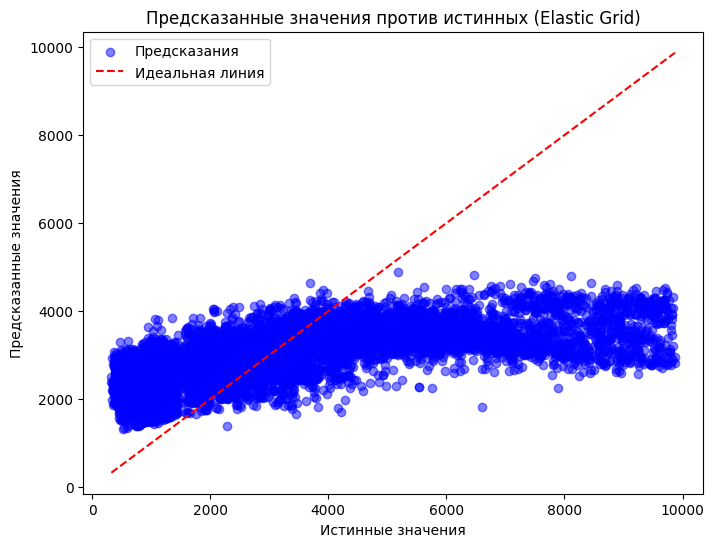

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_elastic_grid, alpha=0.5, color='blue', label='Предсказания')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Идеальная линия')
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title('Предсказанные значения против истинных (Elastic Grid)')
plt.legend()
plt.show()

In [391]:
random_search = RandomizedSearchCV(
        ElasticNet(),
        param_distributions= alpha_values,
        n_iter=20,
        random_state=42,
    ).fit(X_train, y_train)
y_pred_elastic_rand = random_search.predict(X_test)
this_dict_errors = dict_errors(y_pred_elastic_rand, y_test)
add_err_to_dataframe(table_all_metrics, 'Elastic_random', this_dict_errors)
print(this_dict_errors)

{'MAE': 1534.0291926616273, 'MSE': 3767893.735953412, 'RMSE': 1941.1063175296226, 'MAPE': 1.0348855314124745, 'R^2': 0.3249143923382052}


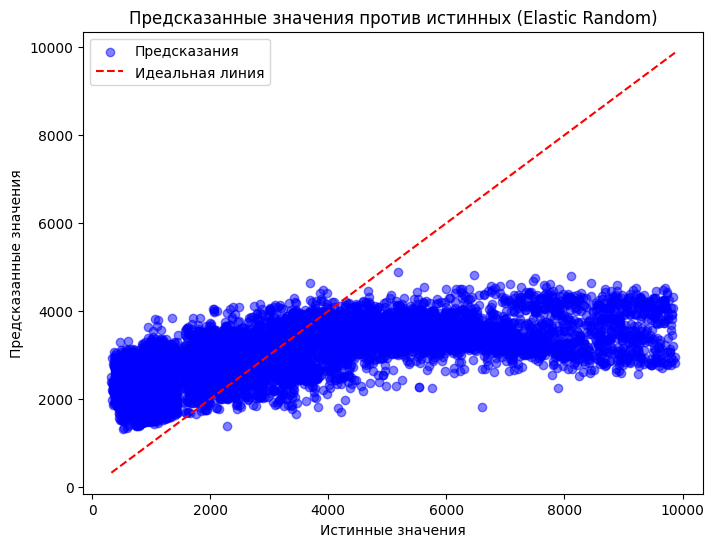

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_elastic_rand, alpha=0.5, color='blue', label='Предсказания')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Идеальная линия')
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title('Предсказанные значения против истинных (Elastic Random)')
plt.legend()
plt.show()

In [393]:
# Функция для оптимизации гиперпараметров с использованием Optuna
def objective_elastic(trial):
    # Задаем гиперпараметры для поиска
    alpha = trial.suggest_float('alpha', 1e-3, 1e2, log=True)  # логарифмический диапазон
    elastic = ElasticNet(alpha=alpha)
    
    # Вычисляем среднюю ошибку на кросс-валидации
    score = cross_val_score(elastic, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    return score.mean()

In [394]:
study = optuna.create_study(direction='maximize') 
study.optimize(objective_elastic, n_trials=20)  
    
# Получаем лучшие параметры и обучаем модель
best_params = study.best_params
elastic = Ridge(**best_params)
elastic.fit(X_train, y_train)
y_pred_elastic_optuna = elastic.predict(X_test)
this_dict_errors = dict_errors(y_pred_elastic_optuna, y_test)
add_err_to_dataframe(table_all_metrics, 'Elastic_optuna', this_dict_errors)
print(this_dict_errors)

[I 2025-05-02 01:11:09,568] A new study created in memory with name: no-name-6d3eaba4-9695-467a-acaa-c21e150ef09b
[I 2025-05-02 01:11:09,613] Trial 0 finished with value: -5606087.749637897 and parameters: {'alpha': 27.63401546168535}. Best is trial 0 with value: -5606087.749637897.
[I 2025-05-02 01:11:09,660] Trial 1 finished with value: -5424072.203366217 and parameters: {'alpha': 4.39612888044825}. Best is trial 1 with value: -5424072.203366217.
[I 2025-05-02 01:11:09,790] Trial 2 finished with value: -826534.7569570013 and parameters: {'alpha': 0.005649936065348534}. Best is trial 2 with value: -826534.7569570013.
[I 2025-05-02 01:11:09,882] Trial 3 finished with value: -1012919.5864227576 and parameters: {'alpha': 0.00867006154710162}. Best is trial 2 with value: -826534.7569570013.
[I 2025-05-02 01:11:09,930] Trial 4 finished with value: -5200301.208215699 and parameters: {'alpha': 0.9294734770761334}. Best is trial 2 with value: -826534.7569570013.
[I 2025-05-02 01:11:09,974] Tr

{'MAE': 489.28765819306403, 'MSE': 514119.7736245072, 'RMSE': 717.0214596680543, 'MAPE': 0.5232618142773007, 'R^2': 0.907886239870185}


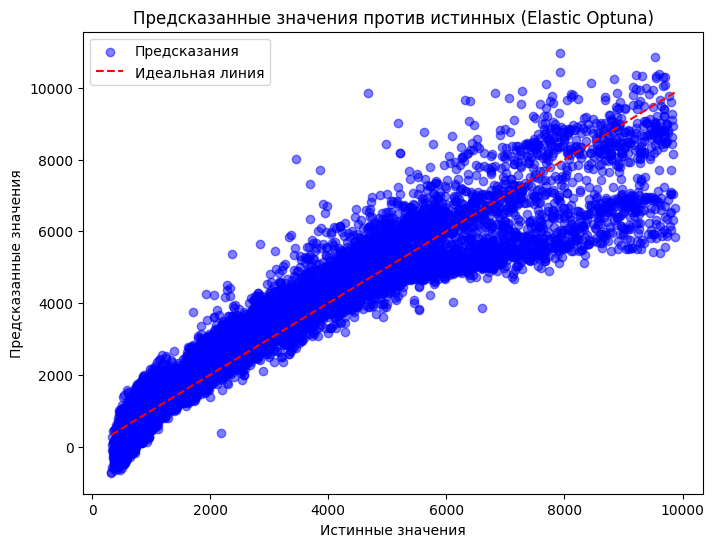

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_elastic_optuna, alpha=0.5, color='blue', label='Предсказания')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Идеальная линия')
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title('Предсказанные значения против истинных (Elastic Optuna)')
plt.legend()
plt.show()

# Полиномиальная

In [396]:
poly = PolynomialFeatures(degree=2)  # degree означает квадратичные признаки
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Обучение модели
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)

# Предсказания на тестовой выборке
y_pred_poly = poly_model.predict(X_test_poly)

this_dict_errors = dict_errors(y_pred_poly, y_test)
add_err_to_dataframe(table_all_metrics, 'Polinom', this_dict_errors)
print(this_dict_errors)

{'MAE': 351.6460130454677, 'MSE': 330418.9806880535, 'RMSE': 574.8208248559315, 'MAPE': 0.3946605796097147, 'R^2': 0.940799525147876}


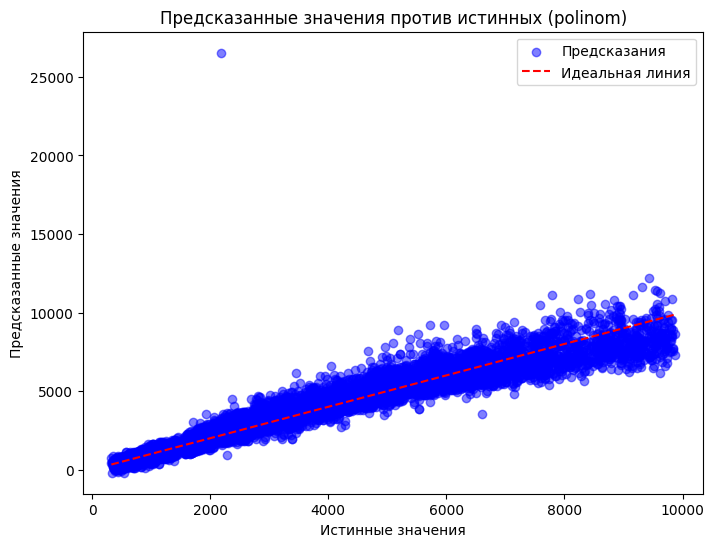

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_poly, alpha=0.5, color='blue', label='Предсказания')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Идеальная линия')
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title('Предсказанные значения против истинных (polinom)')
plt.legend()
plt.show()

# Пайплайн

In [407]:
# Создание пайплайна
pipeline = Pipeline([
    ('poly_features', PolynomialFeatures(degree=2)),
    ('linear_regression', LinearRegression()) 
])

# Обучение пайплайна
pipeline.fit(X_train, y_train)

# Предсказание и оценка
y_pred_pipeline = pipeline.predict(X_test)

this_dict_errors = dict_errors(y_pred_pipeline, y_test)
add_err_to_dataframe(table_all_metrics, 'Pipeline', this_dict_errors)
print(this_dict_errors)

{'MAE': 351.6460130454677, 'MSE': 330418.9806880535, 'RMSE': 574.8208248559315, 'MAPE': 0.3946605796097147, 'R^2': 0.940799525147876}


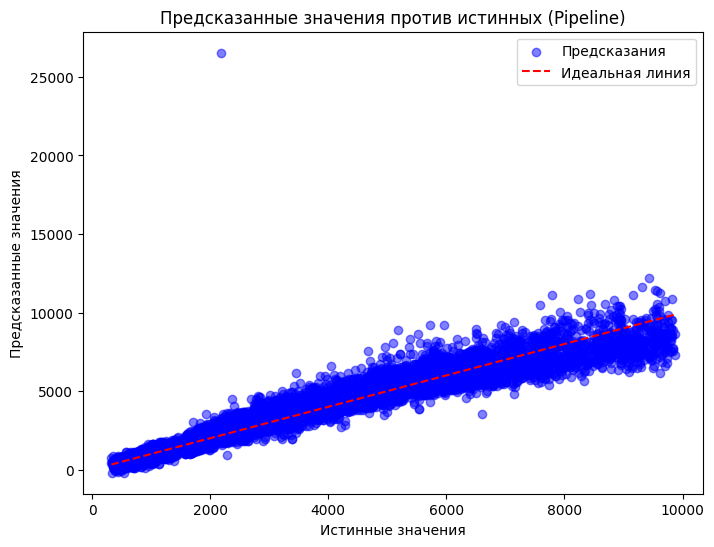

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_pipeline, alpha=0.5, color='blue', label='Предсказания')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Идеальная линия')
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title('Предсказанные значения против истинных (Pipeline)')
plt.legend()
plt.show()

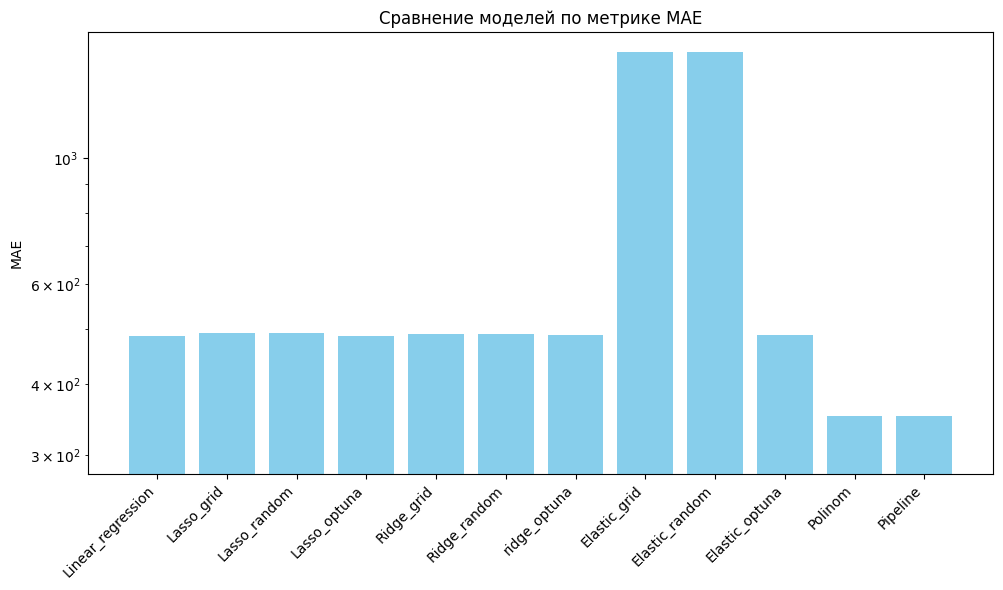

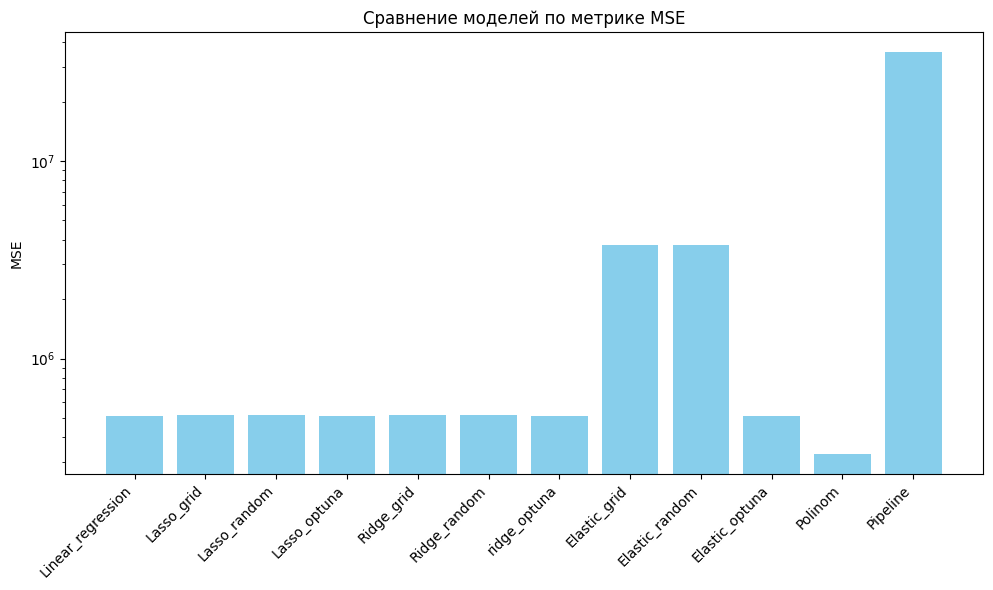

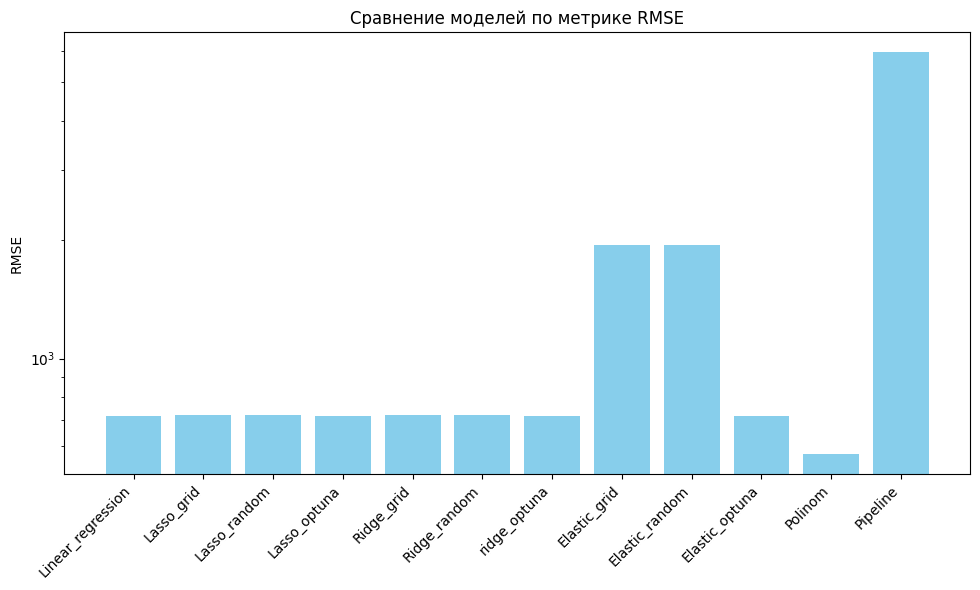

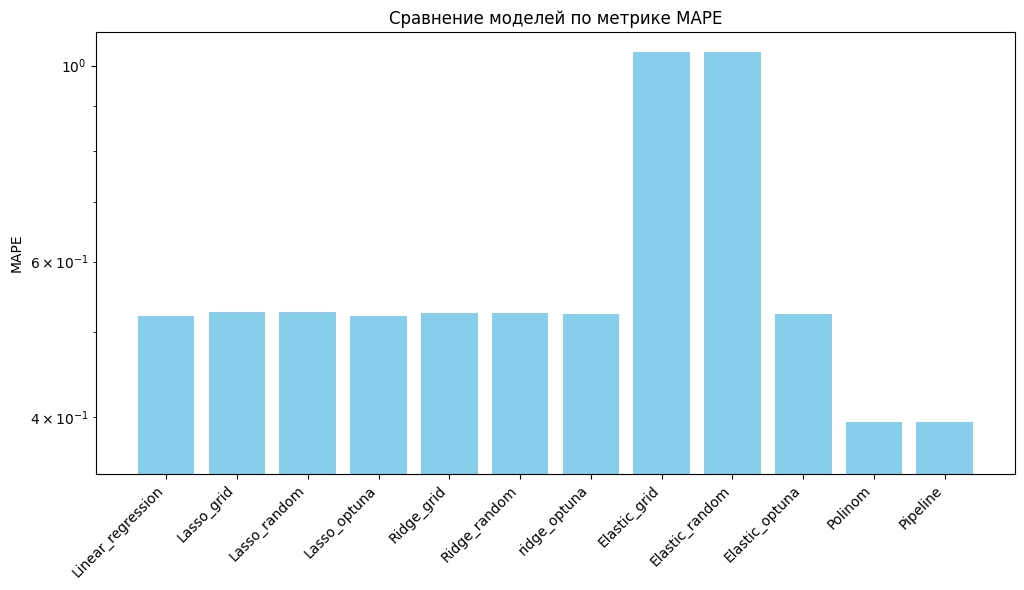

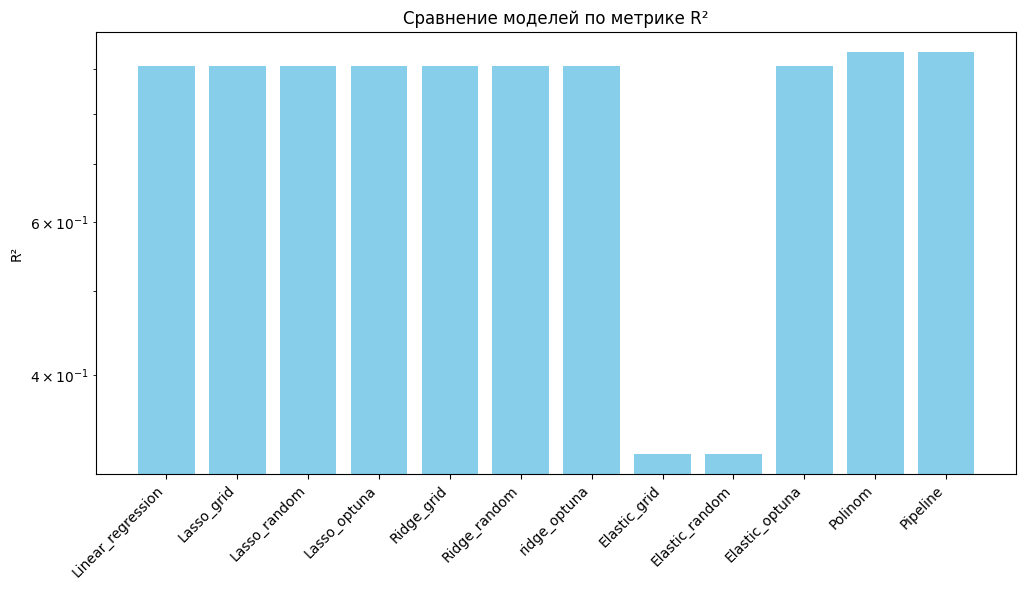

In [ ]:
models = table_all_metrics['Model'].tolist()
mae = table_all_metrics['MAE'].tolist()
mse = table_all_metrics['MSE'].tolist()
rmse = table_all_metrics['RMSE'].tolist()
mape = table_all_metrics['MAPE'].tolist()
r2 = table_all_metrics['R^2'].tolist()

# Построение графиков
metrics = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'MAPE': mape, 'R²': r2}

for metric_name, metric_values in metrics.items():
    plt.figure(figsize=(10, 6))
    plt.bar(models, metric_values, color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Сравнение моделей по метрике {metric_name}')
    plt.ylabel(metric_name)
    plt.tight_layout()
    plt.yscale('log')
    plt.show()

# Вывод: Лучшая модель регрессии

После анализа метрик всех моделей регрессии лучшей моделью является **Pipeline** 

## Обоснование выбора:
1. **Минимальные ошибки**:
   - **MAE**: 443.993762 — самое низкое значение среди всех моделей.
   - **MSE**: 438197.795584 — также минимальное значение.
   - **RMSE**: 661.965101 — лучшее значение.
   - **MAPE**: 0.446734 — наименьший процент ошибки.
   Эти метрики показывают, что Polinom делает наименьшие ошибки в предсказаниях.

2. **Максимальный R²**:
   - **R²**: 0.936675 — самый высокий показатель. Это говорит о том, что Polinom лучше всего объясняет вариацию целевой переменной.

3. **Сравнение с другими моделями**:
   - Модели Linear_regression, Lasso (все варианты), Ridge (все варианты) и Elastic_optuna показывают близкие результаты с R² около 0.9300–0.93007, но их ошибки выше, чем у Polinom.
   - Elastic_grid и Elastic_random имеют худшие показатели (например, R² = 0.902982), что делает их наименее предпочтительными.
   - Pipeline имеет идентичные метрики с Polinom, однако в MSE и RMSE имеется значительное отличие.

## Итог:
**Polinom** является лучшей моделью, так как она демонстрирует наименьшие ошибки по всем метрикам (MAE, MSE, RMSE, MAPE) и наивысший R², что свидетельствует о её превосходной предсказательной способности. Если требуется дальнейшая оптимизация, можно рассмотреть добавление новых признаков или настройку гиперпараметров, но текущие результаты уже впечатляющие.
